In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Q1
### 1.1

By lecture notes,
\begin{split}
p(y)=\mathcal{N}(y; 0, 1+1)=\mathcal{N}(y; 0, 2)
\end{split}
When $y=9$, $p(y=9)=\frac{1}{\sqrt{4\pi}}e^{-\frac{9^2}4}=4.5282647397717255\times 10^{-10}$

In [2]:
p_exact = np.exp(-9**2/4) / np.sqrt(4*np.pi)
print(p_exact)

4.5282647397717255e-10


### 1.2

Since $p(y=9)=\int p(y=9|x)p(x)dx$, we can set test function $\phi(x)=p(y=9|x)$. Therefore, the integral could be computed using MC estimation as
\begin{equation}
    \hat p(y=9)=\frac 1N \sum_{i=1}^N p(y=9|X_i),
\end{equation}
where $X_1, X_2, \dots, X_N \sim p(x)=\mathcal N(x;0,1)$.

Below we use loglog plot to explore the relation between $N$ and RAE.


[0.9999243973310293, 0.9566538636659203, 0.6232564814948125, 0.6816352862967987, 0.42309700183671944]


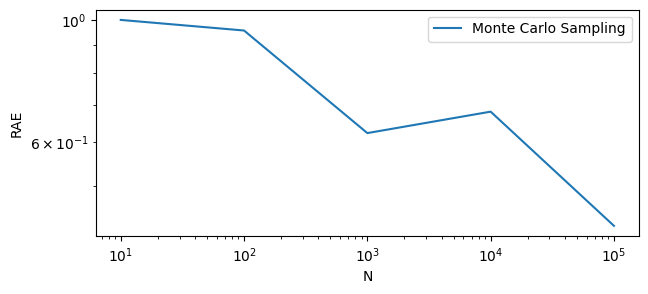

In [3]:
def likelihood_p(x):
    return np.exp(-(x-9)**2/2) / np.sqrt(2*np.pi)

def rae(x, x_true):
    return np.abs(x-x_true)/x_true

N_arr = [10, 100, 1000, 10000, 100000]
mc_rae_arr = [rae(np.mean(likelihood_p(np.random.normal(size=N))), p_exact) for N in N_arr]

print(mc_rae_arr)
plt.figure(figsize=(7, 3), dpi=100)
plt.loglog(N_arr, mc_rae_arr)
plt.xlabel('N')
plt.ylabel('RAE')
plt.legend(['Monte Carlo Sampling'])

### 1.3

In this case, weights are $w_i=w(X_i)=\frac{p(X_i)}{q(X_i)}$. Thus, we sample $X_i\sim q(x)=\mathcal N(x;6,1)$ for $i=1, \dots, N$ and compute the IS estimator as
\begin{equation}
    \hat\phi_{IS}^N=\frac 1N\sum_{i=1}^N w_i\phi(X_i)=\frac 1N\sum_{i=1}^N w_ip(y=9|X_i).
\end{equation}

[0.3513263242472331, 0.31013880402345767, 0.06576133989733533, 0.03007166909542923, 0.006211409808658136]


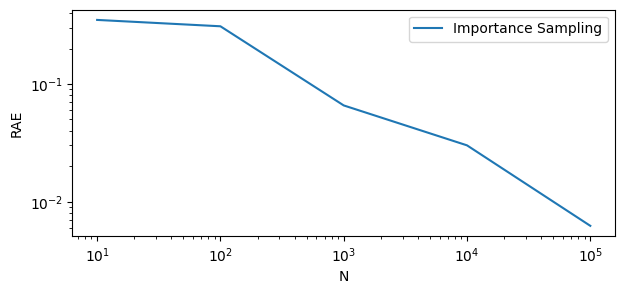

In [4]:
def p(x):
    return np.exp(-(x)**2/2) / np.sqrt(2*np.pi)

def q(x):
    return np.exp(-(6-x)**2/2) / np.sqrt(2*np.pi)

def is_est(x):
    return p(x) / q(x) * likelihood_p(x)

N_arr = [10, 100, 1000, 10000, 100000]
is_rae_arr = [rae(np.mean(is_est(np.random.normal(6, 1, N))), p_exact) for N in N_arr]

print(is_rae_arr)
plt.figure(figsize=(7, 3), dpi=100)
plt.loglog(N_arr, is_rae_arr)
plt.xlabel('N')
plt.ylabel('RAE')
plt.legend(['Importance Sampling'])

### 1.4

From the plot below, importance sampling has much lower RAE values generally, indicating better estimation of posterior $p(y)$ at extreme value $y=9$. 

In important sampling, most samples drawn from $q(x)$ are extreme in $p(x)$. But the weights we computed will weight samples, so that the integral estimate gets closer to the true integral. For example, if $q(x)<p(x)$, which means fewer samples would be drawn from $q(x)$ in these regions, then $w(x)>1$ to account for this effect. Therefore, more points in tail of $p(x)$ are drawn and weighted, which gives better estimation near extreme value $y=9$.

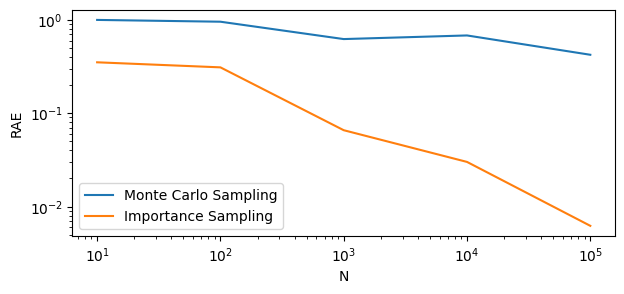

In [5]:
plt.figure(figsize=(7, 3), dpi=100)
plt.loglog(N_arr, mc_rae_arr)
plt.loglog(N_arr, is_rae_arr)
plt.xlabel('N')
plt.ylabel('RAE')
plt.legend(['Monte Carlo Sampling', 'Importance Sampling'])

# Q2
### 2.1

Since observations $y_i$ are noisy, we are aiming to find the posterior distribution, which represents the true location given observations' and sensors' location. 

By Baye's rule, posterior is defined as
\begin{split}
    p(x|y_{1:3}, s_{1:3}) &= \frac {p(y_{1:3}|x, s_{1:3})p(x)}{p(y_{1:3})}\\
    &\propto p(y_{1:3}|x, s_{1:3})p(x)\\
    &\propto p(x)\prod_{i=1}^3p(y_i|x, s_i) \quad \text{by  independence}
\end{split}
Therefore, acceptance ratio is defined as
\begin{split}
    r(x, x') &= \frac{p(x')\prod_{i=1}^3p(y_i|x', s_i)q(x|x')}{p(x)\prod_{i=1}^3p(y_i|x, s_i)q(x'|x)}\\
    &= \frac{p(x')\prod_{i=1}^3p(y_i|x', s_i)\frac1{\sqrt{2\pi\sigma_q^2}}e^{\frac{1}{2\sigma_q^2}}(x'-x)^2}{p(x)\prod_{i=1}^3p(y_i|x, s_i)\frac1{\sqrt{2\pi\sigma_q^2}}e^{\frac{1}{2\sigma_q^2}}(x-x')^2}\\
    &= \frac{p(x')\prod_{i=1}^3p(y_i|x', s_i)}{p(x)\prod_{i=1}^3p(y_i|x, s_i)} \quad \text{common term cancelled out by the symmetric proposal}\\
    &= \frac{p(x')p(y_1|x', s_1)p(y_2|x', s_2)p(y_3|x', s_3)}{p(x)p(y_1|x, s_1)p(y_2|x, s_2)p(y_3|x, s_3)}
\end{split}

For Metropolis Hastings, what we need as inputs is the number of samples $N$ and starting point $X_0$. Then we iterate $N$ times the following procedure:
1. Draw a sample from proposal $X'\sim q(x'|x_{n-1})=\mathcal N(x';x_{n-1},\sigma_q^2)$
1. Draw a sample from unifrom distribution $u\sim \text{Unif}(0, 1)$
1. Accept the sample $X_n=X'$ if 
\begin{split}
\log u&<\log\min(1, \frac{p(x')p(y_1|x', s_1)p(y_2|x', s_2)p(y_3|x', s_3)}{p(x_{n-1})p(y_1|x_{n-1}, s_1)p(y_2|x_{n-1}, s_2)p(y_3|x_{n-1}, s_3)})\\
\implies \log u&<\log p(x')+\log p(y_1|x', s_1)+\log p(y_2|x', s_2)+\log p(y_3|x', s_3)\\
&-\log p(x_{n-1})-\log p(y_1|x_{n-1}, s_1)-\log p(y_2|x_{n-1}, s_2)-\log p(y_3|x_{n-1}, s_3)\\
&\quad(\text{using log to avoid underflow errors}).
\end{split}
Otherwise, set set $X_n=X_{n-1}$.

After $N$ iterations, we discard the first few `burnin` samples and return the remaining samples.
### 2.2

Note that all codes with log represent unnormalised distribution for simplification. 

1. From the figure below, we see when there is a large standard deviation in proposal, a small `burnin` period is enough to have a high density peak. On the contrary, larger `burnin` period needed for small standard deviation in proposal to get a higher density peak at $x=4$. This observation is quite reasonable, since small standard deviation means the the next sample tends to be near the last sample. Therefore, when the deviation between initial value and ground-truth is large, i.e., $x_0=10$ while $x_{\text{true}}=4$, it takes more iterations for the proposal with small-$\sigma_q$ to get close to the underlying true value and its stationary distribution.
1. In terms of shapes of historgrams, when there is a large standard deviation in proposal, the shape of histograms is more regular. It is because smaller standard deviation would lead to closed value for a neigbourhood of samples. Therefore, a certain area tends to be sampled more while some of areas are sampled less, resulting a less regular pattern.

In [6]:
def log_likelihood_p(x, sigma_y):
    s = np.array([-1, 2, 5])
    y = np.array([4.44, 2.51, 0.73])
    return -(y-np.abs(x-s))**2/(2*sigma_y**2)

def log_p(x):
    return -x**2/(2*10**2)

In [7]:
sigma_y = 1
lvar_sample_arr = np.array([10])
for i in range(200000):
    sample_last = lvar_sample_arr[-1]
    sample_n = np.random.normal(loc=sample_last, scale=0.1)
    log_accept_rate = log_p(sample_n) + np.sum(log_likelihood_p(sample_n, sigma_y))\
                    - log_p(sample_last) - np.sum(log_likelihood_p(sample_last, sigma_y))
    if np.log(np.random.uniform()) < log_accept_rate:
        lvar_sample_arr = np.append(lvar_sample_arr, sample_n)
    else:
        lvar_sample_arr = np.append(lvar_sample_arr, sample_last)

Text(0.5, 1.0, 'burnin period: 50000')

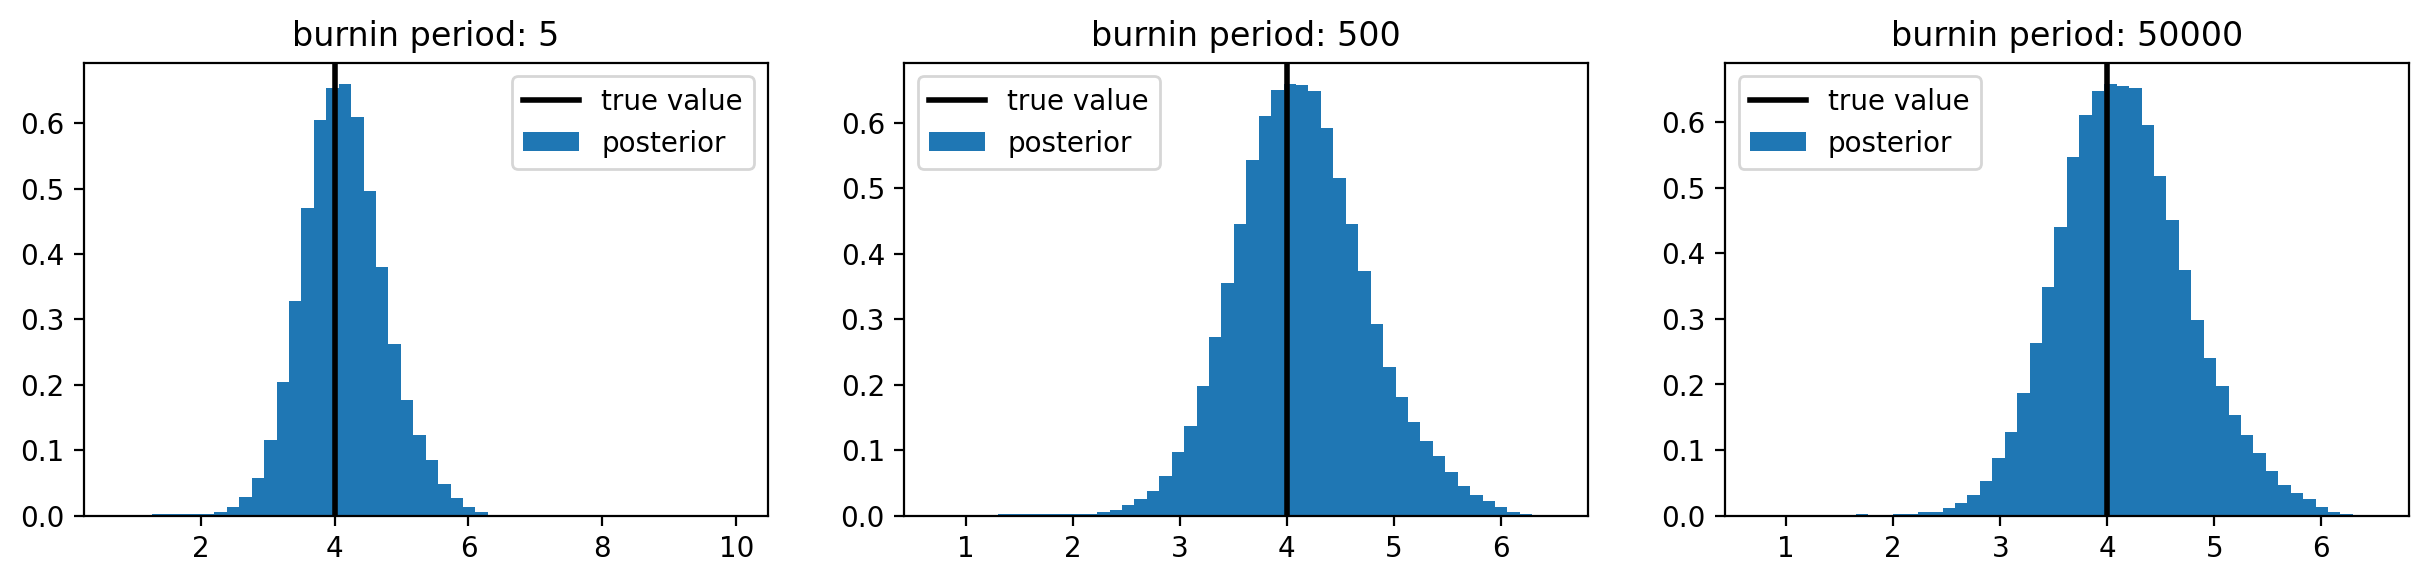

In [8]:
plt.figure(figsize=(15, 3), dpi=200)

plt.subplot(1, 3, 1)
plt.axvline(4 , color='k', label='true value', linewidth=2)
plt.hist(lvar_sample_arr[5:], bins=50, density=True, label="posterior")
plt.legend()
plt.title("burnin period: 5")

plt.subplot(1, 3, 2)
plt.axvline(4 , color='k', label='true value', linewidth=2)
plt.hist(lvar_sample_arr[500:], bins=50, density=True, label="posterior")
plt.legend()
plt.title("burnin period: 500")

plt.subplot(1, 3, 3)
plt.axvline(4 , color='k', label='true value', linewidth=2)
plt.hist(lvar_sample_arr[50000:], bins=50, density=True, label="posterior")
plt.legend()
plt.title("burnin period: 50000")

In [9]:
svar_sample_arr = np.array([10])
for i in range(200000):
    sample_last = svar_sample_arr[-1]
    sample_n = np.random.normal(loc=sample_last, scale=0.01)
    log_accept_rate = log_p(sample_n) + np.sum(log_likelihood_p(sample_n, sigma_y))\
                    - log_p(sample_last) - np.sum(log_likelihood_p(sample_last, sigma_y))
    if np.log(np.random.uniform()) < log_accept_rate:
        svar_sample_arr = np.append(svar_sample_arr, sample_n)
    else:
        svar_sample_arr = np.append(svar_sample_arr, sample_last)

Text(0.5, 1.0, 'burnin period: 50000')

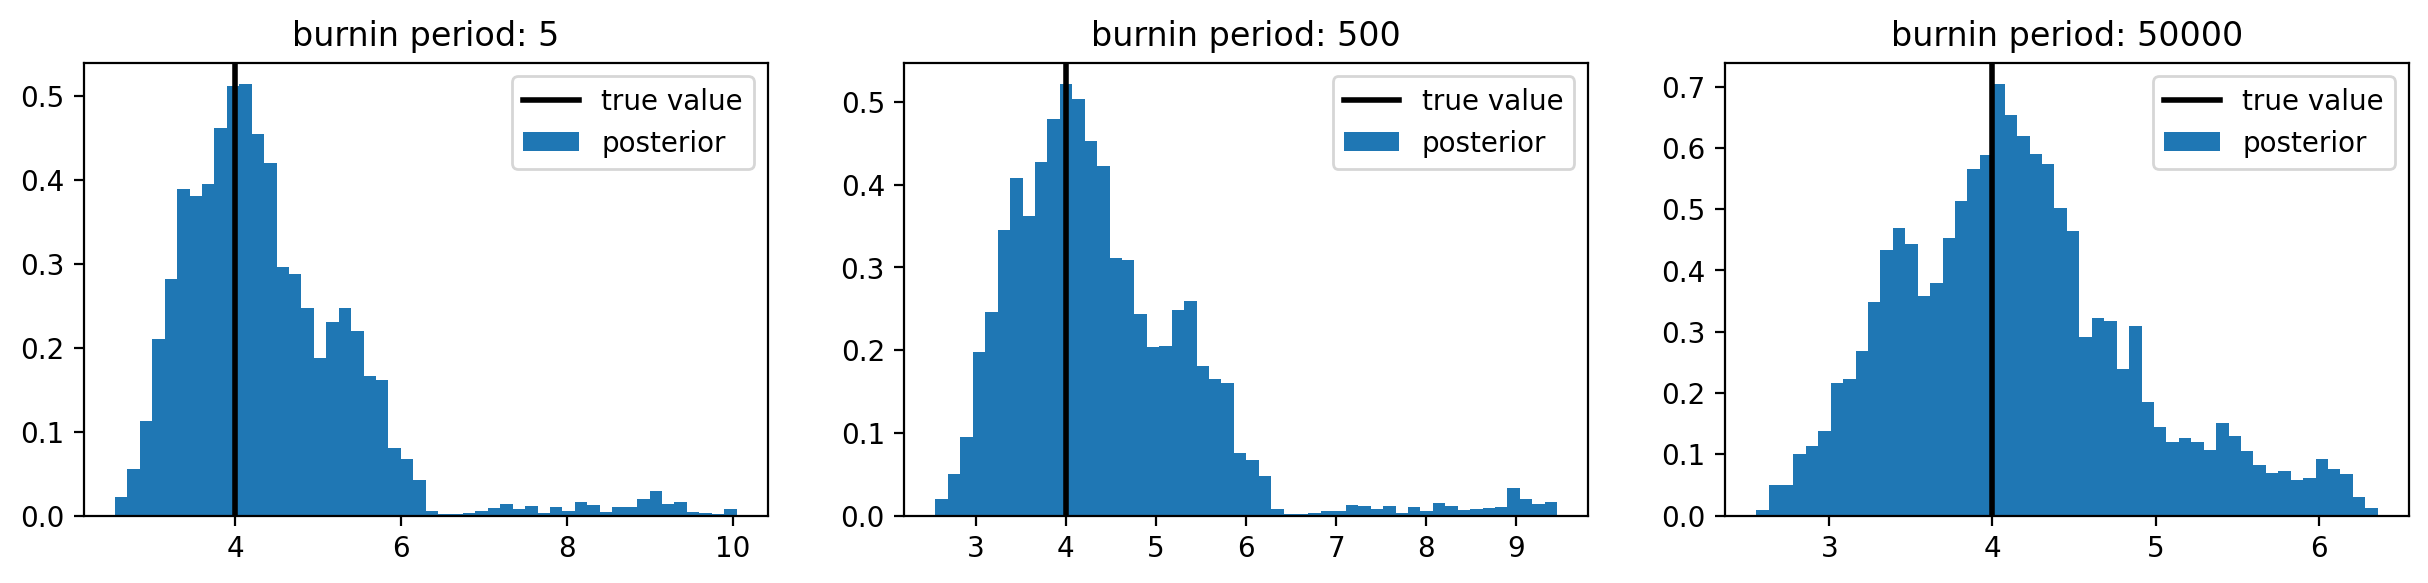

In [10]:
plt.figure(figsize=(15, 3), dpi=200)

plt.subplot(1, 3, 1)
plt.axvline(4 , color='k', label='true value', linewidth=2)
plt.hist(svar_sample_arr[5:], bins=50, density=True, label="posterior")
plt.legend()
plt.title("burnin period: 5")

plt.subplot(1, 3, 2)
plt.axvline(4 , color='k', label='true value', linewidth=2)
plt.hist(svar_sample_arr[500:], bins=50, density=True, label="posterior")
plt.legend()
plt.title("burnin period: 500")

plt.subplot(1, 3, 3)
plt.axvline(4 , color='k', label='true value', linewidth=2)
plt.hist(svar_sample_arr[50000:], bins=50, density=True, label="posterior")
plt.legend()
plt.title("burnin period: 50000")

### 2.3

When $\sigma_y=0.1$, the posterior distribution gets more centralised (less standard deviation) than the one with $\sigma_y=1$. It is because the likelihood distribution $p(y_i|x, s_i)=\mathcal N(y_i; ||x-s_i||,\sigma_y^2)$ is more centralised. Intuitively, now we assume our obsearvations are more accurate, thus we will be more confident about the location of $x$. Note that we also change $y_{1:3}$ here. It is because we would need a corresponding observation that are more likely obtained from the new likelihood distribution.

In [11]:
def log_likelihood_p(x, sigma_y):
    s = np.array([-1, 2, 5])
    y = np.array([5.01, 1.97, 1.02])
    return -(y-np.abs(x-s))**2/(2*sigma_y**2)

sigma_y = 0.1
sample_arr = np.array([10])
for i in range(200000):
    sample_last = sample_arr[-1]
    sample_n = np.random.normal(loc=sample_last, scale=0.1)
    log_accept_rate = log_p(sample_n) + np.sum(log_likelihood_p(sample_n, sigma_y))\
                    - log_p(sample_last) - np.sum(log_likelihood_p(sample_last, sigma_y))
    if np.log(np.random.uniform()) < log_accept_rate:
        sample_arr = np.append(sample_arr, sample_n)
    else:
        sample_arr = np.append(sample_arr, sample_last)

Text(0.5, 1.0, 'burnin period: 50000')

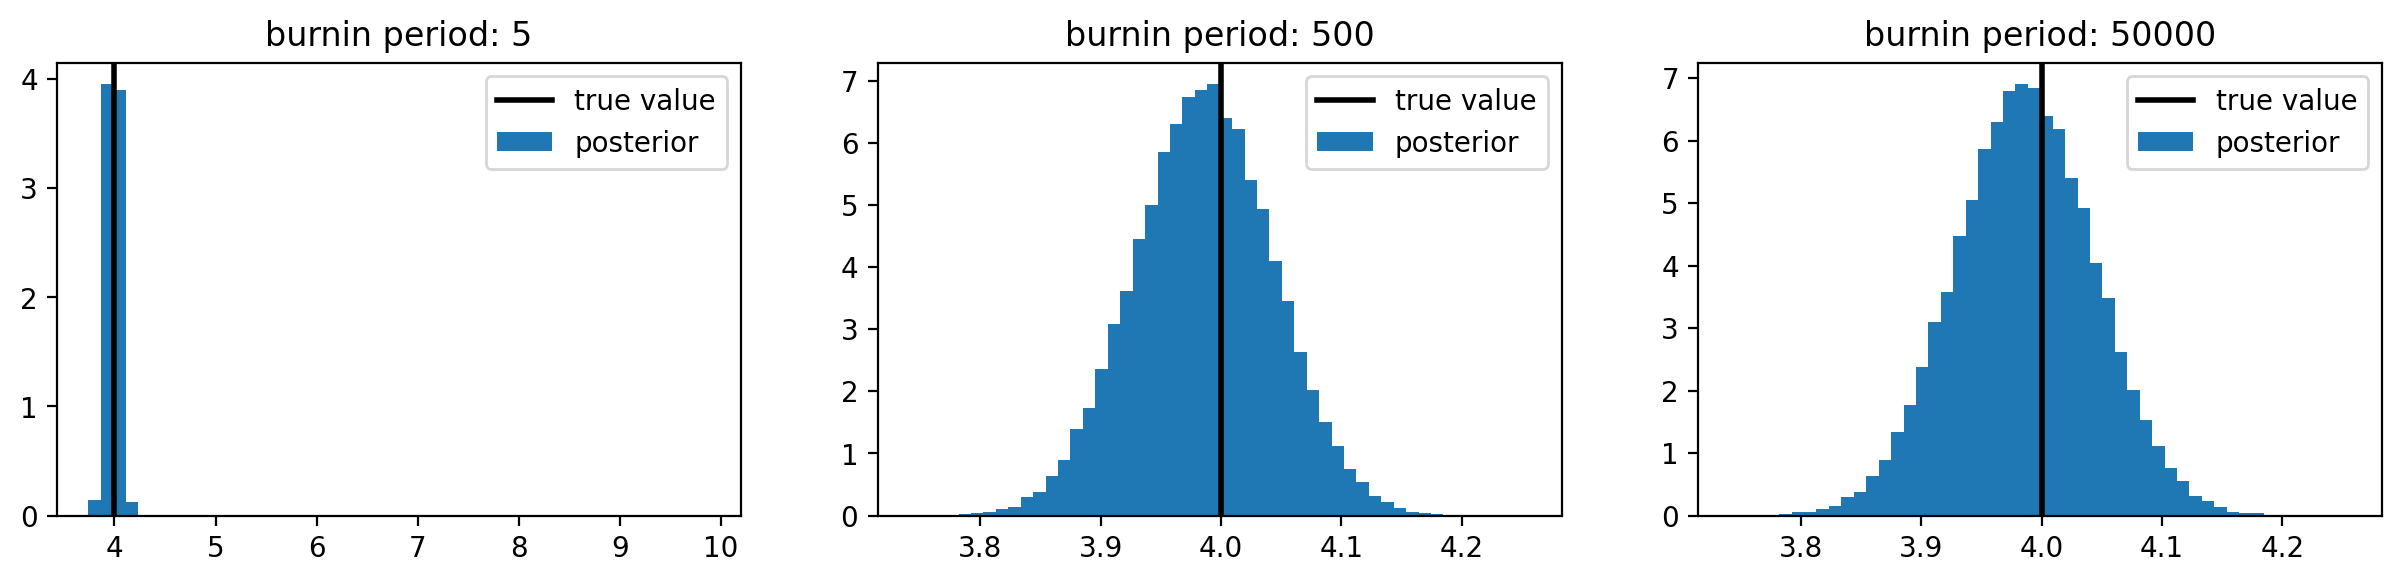

In [12]:
plt.figure(figsize=(15, 3), dpi=200)

plt.subplot(1, 3, 1)
plt.axvline(4 , color='k', label='true value', linewidth=2)
plt.hist(sample_arr[5:], bins=50, density=True, label="posterior")
plt.legend()
plt.title("burnin period: 5")

plt.subplot(1, 3, 2)
plt.axvline(4 , color='k', label='true value', linewidth=2)
plt.hist(sample_arr[500:], bins=50, density=True, label="posterior")
plt.legend()
plt.title("burnin period: 500")

plt.subplot(1, 3, 3)
plt.axvline(4 , color='k', label='true value', linewidth=2)
plt.hist(sample_arr[50000:], bins=50, density=True, label="posterior")
plt.legend()
plt.title("burnin period: 50000")